In [4]:
import numpy as np
import pandas as pd
import os

import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
import time
# import sequential model
from tensorflow.keras.models import Sequential

# import kernel regularizers l2
from tensorflow.keras.regularizers import l2

!pip install albumentations


In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [9]:
#data_directory = r'../../../Dataset/UsedDataset/DiseasedPlants/Pertanian/Jagung'
data_directory = r'/kaggle/input/agronify-dataset/DiseasedPlants/Pertanian/Cabai'

min_samples = 50

filepaths = []
labels = []
class_list = os.listdir(data_directory)

for class_name in class_list:
    class_path = os.path.join(data_directory, class_name)
    file_list = os.listdir(class_path)

    if len(file_list) >= min_samples:
        for file_name in file_list:
            file_path = os.path.join(class_path, file_name)
            filepaths.append(file_path)
            labels.append(class_name)
    else:
        print('Class', class_name,
              'has only', len(file_list),
              'samples and will not be included in the dataframe')

filepaths_series = pd.Series(filepaths, name='filepaths')
labels_series = pd.Series(labels, name='labels')
df = pd.concat([filepaths_series, labels_series], axis=1)

train_df, dummy_df = train_test_split(df,
                                      train_size=0.7,
                                      shuffle=True,
                                      random_state=42,
                                      stratify=df['labels'])
valid_df, test_df = train_test_split(dummy_df,
                                     train_size=1/2,
                                     shuffle=True,
                                     random_state=42,
                                     stratify=dummy_df['labels'])

print('train_df length:', len(train_df),
      'test_df length:', len(test_df),
      'valid_df length:', len(valid_df))

classes = sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is:', class_count)

groups = train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))

count_list = []
class_list = []

for label in sorted(list(train_df['labels'].unique())):
    group = groups.get_group(label)
    count_list.append(len(group))
    class_list.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

max_value = np.max(count_list)
max_index = count_list.index(max_value)
max_class = class_list[max_index]

min_value = np.min(count_list)
min_index = count_list.index(min_value)
min_class = class_list[min_index]

print(max_class, 'has the most images:', max_value, ',',
      min_class, 'has the least images:', min_value)

height_total = 0
width_total = 0
train_df_sample = train_df.sample(n=100, random_state=123, axis=0)

for i in range(len(train_df_sample)):
    file_path = train_df_sample['filepaths'].iloc[i]
    img = plt.imread(file_path)
    shape = img.shape
    height_total += shape[0]
    width_total += shape[1]

print('Average height:', height_total // 100,
      'Average width:', width_total // 100,
      'Aspect ratio:', height_total / width_total)

train_df length: 350 test_df length: 75 valid_df length: 75
The number of classes in the dataset is: 5
            CLASS               IMAGE COUNT 
        Chili__healthy              70      
       Chili__leaf curl             70      
       Chili__leaf spot             70      
       Chili__whitefly              70      
       Chili__yellowish             70      
Chili__healthy has the most images: 70 , Chili__healthy has the least images: 70
Average height: 192 Average width: 233 Aspect ratio: 0.8251347420651894


In [14]:
def balance_dataframe(dataframe, target_samples, working_directory, image_size):
    dataframe = dataframe.copy()
    print('Initial length of the dataframe is', len(dataframe))
    augmented_directory = os.path.join(working_directory, 'aug')

    if os.path.isdir(augmented_directory):
        shutil.rmtree(augmented_directory)
    os.mkdir(augmented_directory)

    for label in dataframe['labels'].unique():
        class_directory = os.path.join(augmented_directory, label)
        os.mkdir(class_directory)

    total_augmented = 0
    image_generator = ImageDataGenerator(
        rescale=1./255, # rescale the pixel values to be between 0 and 1
        rotation_range=40, # randomly rotate the image by up to 40 degrees
        width_shift_range=0.2, # randomly shift the image horizontally by up to 20% of the width
        height_shift_range=0.2, # randomly shift the image vertically by up to 20% of the height
        shear_range=0.2, # randomly shear the image by up to 20%
        zoom_range=0.2, # randomly zoom in on the image by up to 20%
        horizontal_flip=True, # randomly flip the image horizontally
        fill_mode='nearest' # fill in any empty pixels with the nearest pixel value
    )
    groups = dataframe.groupby('labels')

    for label in dataframe['labels'].unique():
        group = groups.get_group(label)
        sample_count = len(group)

        if sample_count < target_samples:
            delta = target_samples - sample_count
            target_directory = os.path.join(augmented_directory, label)
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            #msg = 'Creating {0} augmented images for class {1}'.format(delta, label)
            print(msg, '\r', end='')

            augmentation_generator = image_generator.flow_from_dataframe(group,
                                                                         x_col='filepaths',
                                                                         y_col=None,
                                                                         target_size=image_size,
                                                                         class_mode=None,
                                                                         batch_size=1,
                                                                         shuffle=False,
                                                                         save_to_dir=target_directory,
                                                                         save_prefix='aug-',
                                                                         color_mode='rgb',
                                                                         save_format='jpg')

            augmented_image_count = 0

            while augmented_image_count < delta:
                images = next(augmentation_generator)
                augmented_image_count += len(images)

            total_augmented += augmented_image_count

    print('Total augmented images created:', total_augmented)

    augmented_filepaths = []
    augmented_labels = []
    class_list = os.listdir(augmented_directory)

    for class_name in class_list:
        class_path = os.path.join(augmented_directory, class_name)
        file_list = os.listdir(class_path)

        for file_name in file_list:
            file_path = os.path.join(class_path, file_name)
            augmented_filepaths.append(file_path)
            augmented_labels.append(class_name)

    augmented_filepaths_series = pd.Series(augmented_filepaths, name='filepaths', dtype='object')
    augmented_labels_series = pd.Series(augmented_labels, name='labels', dtype='object')

    augmented_df = pd.concat([augmented_filepaths_series, augmented_labels_series], axis=1)

    dataframe = pd.concat([dataframe, augmented_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now', len(dataframe))

    return dataframe


target_samples = 250
working_directory = r'./'
image_size = (224, 224)
train_df = balance_dataframe(train_df, target_samples, working_directory, image_size)

Initial length of the dataframe is 350
Found 70 validated image filenames.      for class        Chili__whitefly         creating  180  augmented images 
Found 70 validated image filenames.      for class        Chili__leaf curl        creating  180  augmented images 
Found 70 validated image filenames.      for class         Chili__healthy         creating  180  augmented images 
Found 70 validated image filenames.      for class        Chili__leaf spot        creating  180  augmented images 
Found 70 validated image filenames.      for class        Chili__yellowish        creating  180  augmented images 
Total augmented images created: 900
Length of augmented dataframe is now 1250


In [15]:
train_batch_size = 64
train_data_generator = ImageDataGenerator(horizontal_flip=True,
                                          rotation_range=20,
                                          width_shift_range=.2,
                                          height_shift_range=.2,
                                          zoom_range=.2)
t_and_v_data_generator = ImageDataGenerator()

train_message = '{0:70s} for train generator'.format(' ')
print(train_message, '\r', end='')

train_generator = train_data_generator.flow_from_dataframe(train_df,
                                                           x_col='filepaths',
                                                           y_col='labels',
                                                           target_size=image_size,
                                                           class_mode='categorical',
                                                           color_mode='rgb',
                                                           shuffle=True,
                                                           batch_size=train_batch_size)

valid_message = '{0:70s} for valid generator'.format(' ')
print(valid_message, '\r', end='')

valid_generator = t_and_v_data_generator.flow_from_dataframe(valid_df,
                                                             x_col='filepaths',
                                                             y_col='labels',
                                                             target_size=image_size,
                                                             class_mode='categorical',
                                                             color_mode='rgb',
                                                             shuffle=False,
                                                             batch_size=train_batch_size)

test_length = len(test_df)
test_batch_size = sorted([int(test_length/n) for n in range(1, test_length+1) if test_length % n == 0 and test_length/n <= 80], reverse=True)[0]
test_steps = int(test_length / test_batch_size)

test_message = '{0:70s} for test generator'.format(' ')
print(test_message, '\r', end='')

test_generator = t_and_v_data_generator.flow_from_dataframe(test_df,
                                                            x_col='filepaths',
                                                            y_col='labels',
                                                            target_size=image_size,
                                                            class_mode='categorical',
                                                            color_mode='rgb',
                                                            shuffle=False,
                                                            batch_size=test_batch_size)

classes = list(train_generator.class_indices.keys())
class_indices = list(train_generator.class_indices.values())
class_count = len(classes)
labels = test_generator.labels

print('test batch size:', test_batch_size, '  test steps:', test_steps, 'number of classes:', class_count)

Found 1250 validated image filenames belonging to 5 classes.           for train generator 
Found 75 validated image filenames belonging to 5 classes.             for valid generator 
Found 75 validated image filenames belonging to 5 classes.             for test generator 
test batch size: 75   test steps: 1 number of classes: 5


In [ ]:
tf.keras.backend.clear_session()

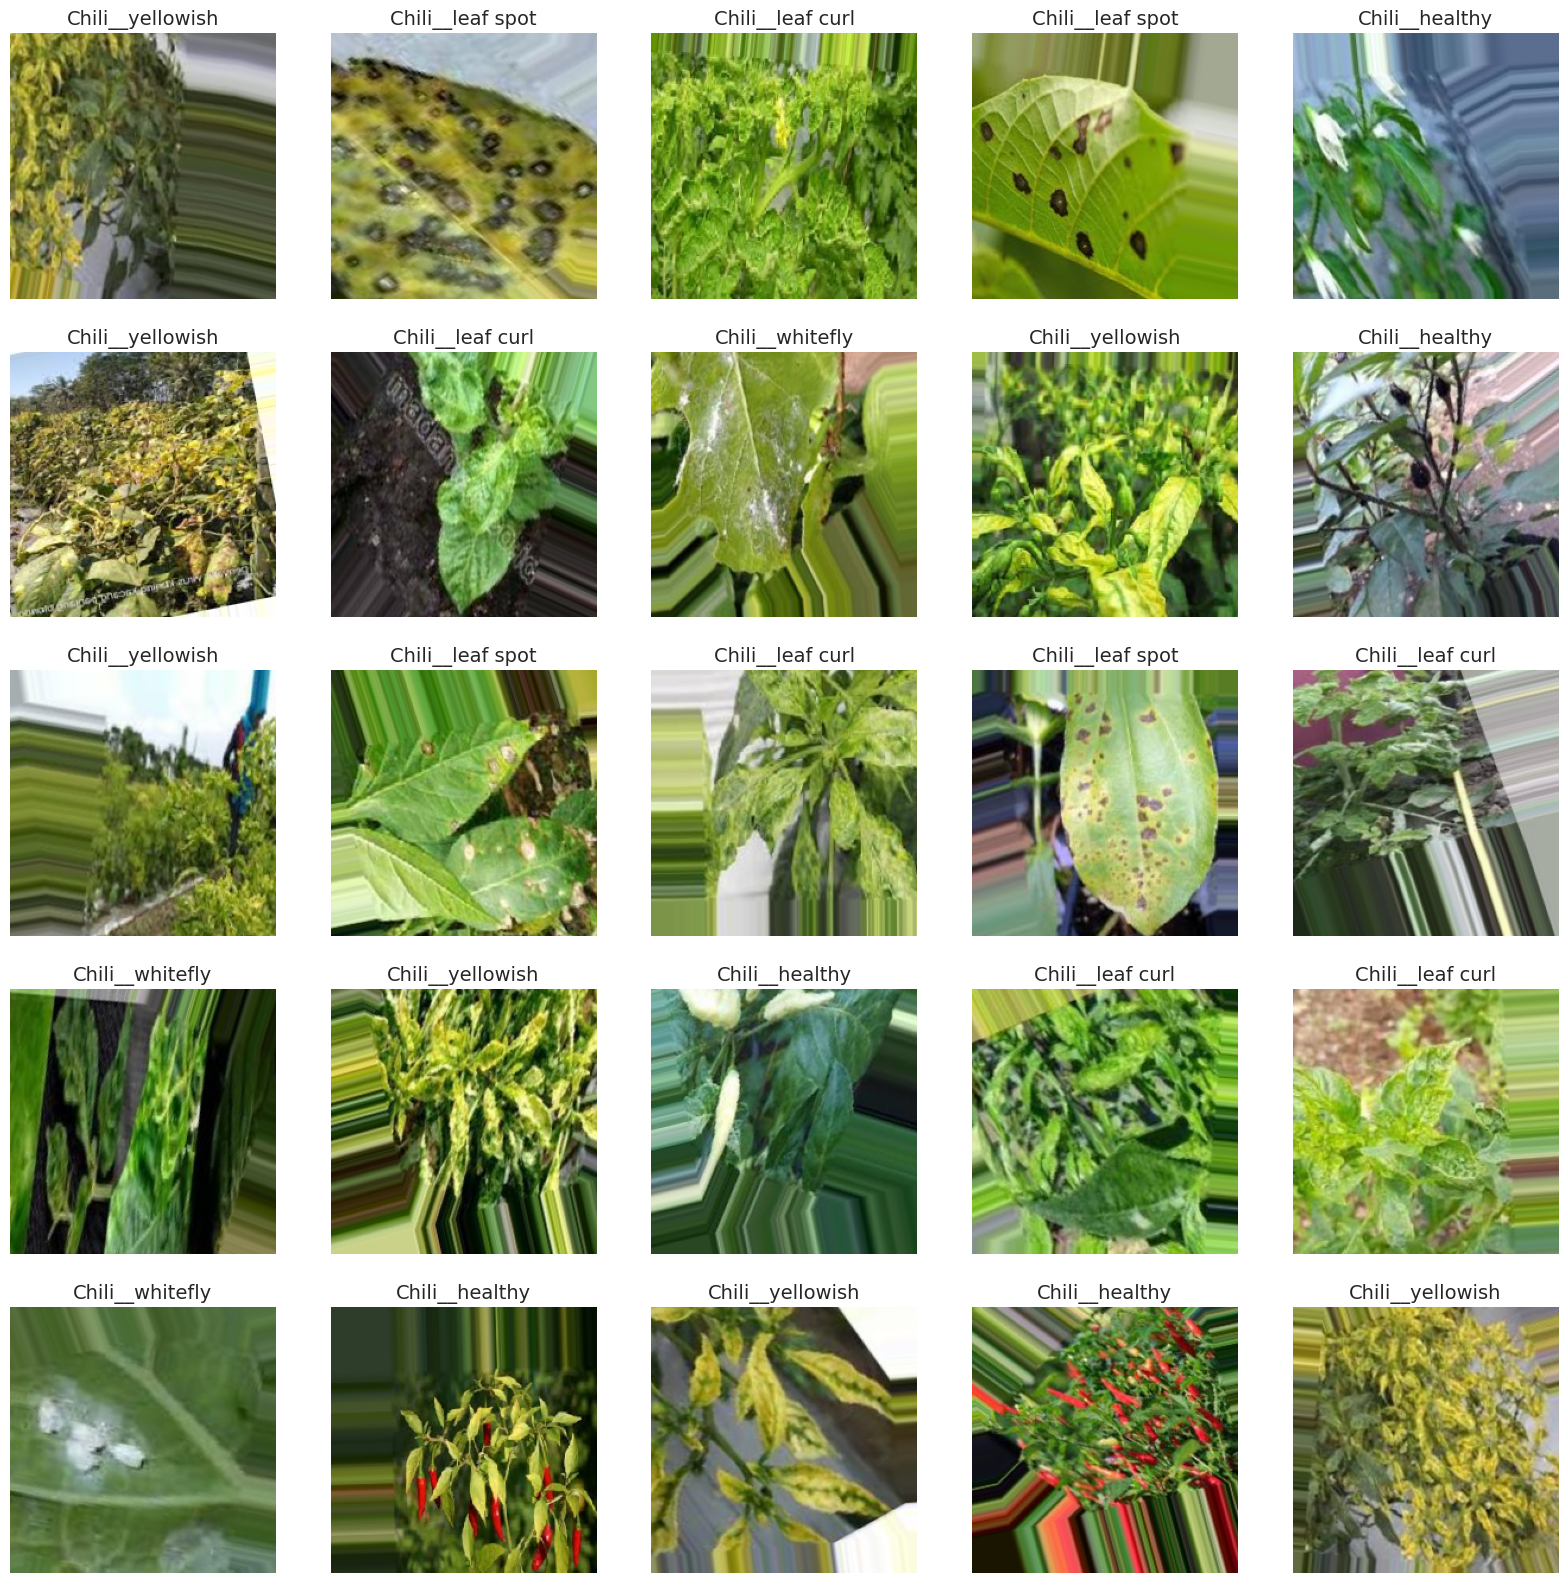

In [16]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i] /255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, fontsize=14)
        plt.axis('off')
    plt.show()

show_image_samples(train_generator)

In [17]:
class LR_ASK(keras.callbacks.Callback):
    def __init__(self, model, total_epochs, ask_epoch):
        super(LR_ASK, self).__init__()
        self.model = model
        self.ask_epoch = ask_epoch
        self.total_epochs = total_epochs
        self.ask = True
        self.lowest_val_loss = np.inf
        self.best_weights = self.model.get_weights()
        self.best_epoch = 1

    def on_train_begin(self, logs=None):
        if self.ask_epoch == 0:
            print('You set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch = 1
        if self.ask_epoch >= self.total_epochs:
            print('ask_epoch >= total_epochs, will train for', self.total_epochs, 'epochs', flush=True)
            self.ask = False
        if self.total_epochs == 1:
            self.ask = False
        else:
            print('Training will proceed until epoch', self.ask_epoch, 'then you will be asked to')
            print('enter H to halt training or enter an integer for how many more epochs to run then be asked again')
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        print('Loading model with weights from epoch', self.best_epoch)
        self.model.set_weights(self.best_weights)
        training_duration = time.time() - self.start_time
        hours = training_duration // 3600
        minutes = (training_duration - (hours * 3600)) // 60
        seconds = training_duration - ((hours * 3600) + (minutes * 60))
        msg = f'Training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg, flush=True)

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        if val_loss < self.lowest_val_loss:
            self.lowest_val_loss = val_loss
            self.best_weights = self.model.get_weights()
            self.best_epoch = epoch + 1
            print(f'\nValidation loss of {val_loss:7.4f} is below the lowest loss, saving weights from epoch {str(epoch + 1):3s} as the best weights')
        else:
            print(f'\nValidation loss of {val_loss:7.4f} is above the lowest loss of {self.lowest_val_loss:7.4f}, keeping weights from epoch {str(self.best_epoch)} as the best weights')

        if self.ask:
            if epoch + 1 == self.ask_epoch:
                print('\nEnter H to end training or an integer for the number of additional epochs to run then ask again')
                ans = input()

                if ans.lower() == 'h' or ans == '0':
                    print('You entered', ans, 'Training halted on epoch', epoch + 1, 'due to user input\n', flush=True)
                    self.model.stop_training = True
                else:
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.total_epochs:
                        print('\nYou specified a maximum of', self.total_epochs, 'epochs. Cannot train for', self.ask_epoch, flush=True)
                    else:
                        print('You entered', ans, 'Training will continue to epoch', self.ask_epoch, flush=True)
                        current_lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
                        print(f'Current learning rate is {current_lr:7.5f}.')

NameError: name 'model' is not defined

In [44]:
tf.keras.backend.clear_session()
del model

In [47]:
from tensorflow.keras.applications import ResNet50

image_shape = (image_size[0], image_size[1], 3)
model_name = 'ResNet50'
base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=image_shape,
    pooling='max'
)


# Set base_model to be trainable
base_model.trainable = True

x = base_model.output
x = Flatten()(x)  # Add a Flatten layer here
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(128,
          kernel_regularizer=regularizers.l2(0.01),
          activity_regularizer=regularizers.l1(0.01),
          bias_regularizer=regularizers.l1(0.01),
          activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(class_count, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(
    Adamax(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [48]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [49]:
total_epochs = 100
ask_epoch = 10
ask_callback = LR_ASK(model,
                      total_epochs,
                      ask_epoch)
rlronp_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                       factor=0.2,
                                                       patience=3,
                                                       verbose=1)
callbacks = [rlronp_callback, ask_callback]
#callbacks = [ask_callback]

In [50]:
epochs=100
# ask_epoch=5
# ask=LR_ASK(model, epochs,  ask_epoch)
# rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=2,verbose=1)
# callbacks=[rlronp, ask]
#callbacks=[ask]

history=model.fit(x=train_generator,
                  epochs=epochs,
                  verbose=1,
                  batch_size=64,
                  callbacks=callbacks,
                  validation_data=valid_generator,
                  shuffle=True,
                  initial_epoch=0)

Training will proceed until epoch 10 then you will be asked to
enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 5.9963 - accuracy: 0.3296
Validation loss of 20.2960 is below the lowest loss, saving weights from epoch 1   as the best weights
20/20 [==============================] - 50s 879ms/step - loss: 5.9963 - accuracy: 0.3296 - val_loss: 20.2960 - val_accuracy: 0.2933 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 5.1637 - accuracy: 0.4872
Validation loss of 11.7070 is below the lowest loss, saving weights from epoch 2   as the best weights
20/20 [==============================] - 17s 855ms/step - loss: 5.1637 - accuracy: 0.4872 - val_loss: 11.7070 - val_accuracy: 0.3600 - lr: 0.0010
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 4.5743 - accuracy: 0.6216
Validation loss of  8.6571 is below the lowest loss, savi

 10


You entered 10 Training will continue to epoch 20
Current learning rate is 0.00100.
20/20 [==============================] - 74s 4s/step - loss: 2.8844 - accuracy: 0.9200 - val_loss: 2.9427 - val_accuracy: 0.8400 - lr: 0.0010
Epoch 11/100
20/20 [==============================] - ETA: 0s - loss: 2.7567 - accuracy: 0.9256
Validation loss of  2.8754 is below the lowest loss, saving weights from epoch 11  as the best weights
20/20 [==============================] - 17s 857ms/step - loss: 2.7567 - accuracy: 0.9256 - val_loss: 2.8754 - val_accuracy: 0.8267 - lr: 0.0010
Epoch 12/100
20/20 [==============================] - ETA: 0s - loss: 2.6254 - accuracy: 0.9344
Validation loss of  2.5570 is below the lowest loss, saving weights from epoch 12  as the best weights
20/20 [==============================] - 17s 833ms/step - loss: 2.6254 - accuracy: 0.9344 - val_loss: 2.5570 - val_accuracy: 0.8800 - lr: 0.0010
Epoch 13/100
20/20 [==============================] - ETA: 0s - loss: 2.5032 - accurac

 H


You entered H Training halted on epoch 20 due to user input

20/20 [==============================] - 20s 995ms/step - loss: 1.8823 - accuracy: 0.9632 - val_loss: 1.9861 - val_accuracy: 0.8133 - lr: 0.0010
Loading model with weights from epoch 20
Training elapsed time was 0.0 hours,  7.0 minutes, 42.14 seconds)


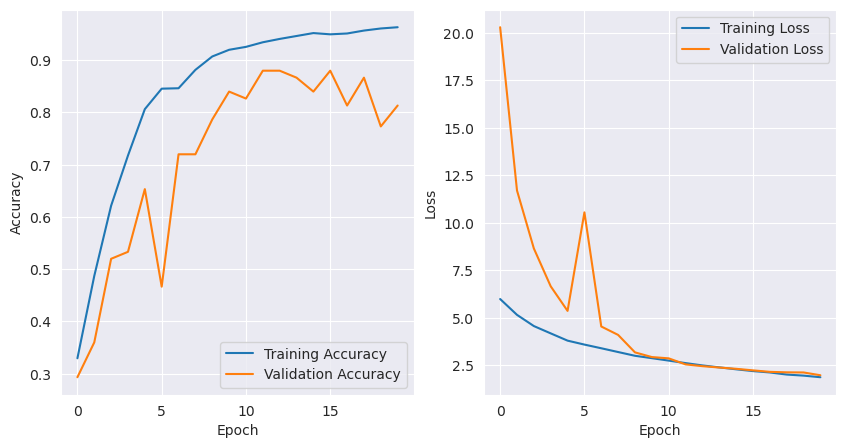

In [51]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

1/1 [==============================] - 2s 2s/step
There were 15 errors in 75 tests for an accuracy of  80.00


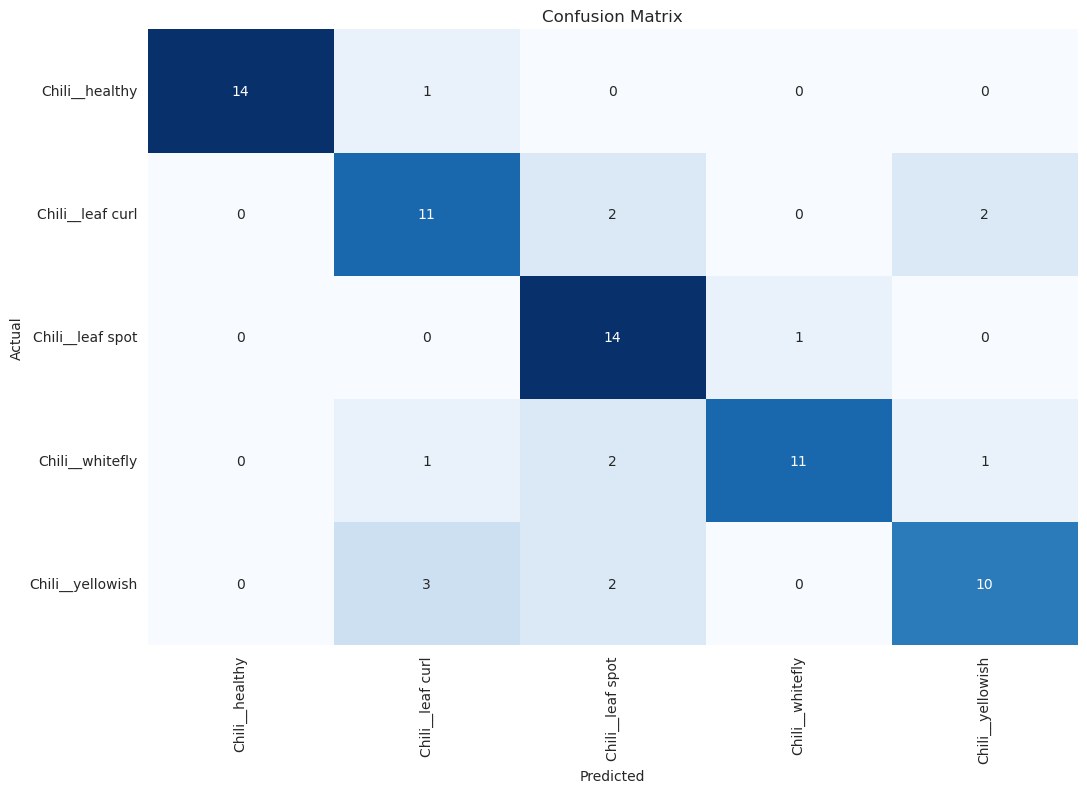

Classification Report:
----------------------
                   precision    recall  f1-score   support

  Chili__healthy     1.0000    0.9333    0.9655        15
Chili__leaf curl     0.6875    0.7333    0.7097        15
Chili__leaf spot     0.7000    0.9333    0.8000        15
 Chili__whitefly     0.9167    0.7333    0.8148        15
Chili__yellowish     0.7692    0.6667    0.7143        15

        accuracy                         0.8000        75
       macro avg     0.8147    0.8000    0.8009        75
    weighted avg     0.8147    0.8000    0.8009        75



In [52]:
def prediction_evaluation(test_gen, test_steps):
    y_pred = []
    y_true = test_gen.labels
    classes = list(test_gen.class_indices.keys())
    class_count = len(classes)
    error_count = 0
    preds = model.predict(test_gen, verbose=1)
    tests = len(preds)

    for i, p in enumerate(preds):
        pred_index = np.argmax(p)
        true_index = test_gen.labels[i]  # labels are integer values
        if pred_index != true_index:  # a misclassification has occurred
            error_count += 1
        y_pred.append(pred_index)

    accuracy = (1 - error_count / tests) * 100
    print(f'There were {error_count} errors in {tests} tests for an accuracy of {accuracy:6.2f}')
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    if class_count <= 30:
        confusion_mat = confusion_matrix(y_true, y_pred)
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(confusion_mat, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count) + .5, classes, rotation=90)
        plt.yticks(np.arange(class_count) + .5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    classification_rep = classification_report(y_true, y_pred, target_names=classes, digits=4)  # create classification report
    print("Classification Report:\n----------------------\n", classification_rep)
    return error_count, tests

errors, tests = prediction_evaluation(test_generator, test_steps)

In [53]:
score = model.evaluate(test_generator, verbose=1)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

1/1 [==============================] - 0s 339ms/step - loss: 2.1495 - accuracy: 0.8000
Test loss: 2.1494829654693604 / Test accuracy: 0.800000011920929


2/2 [==============================] - 2s 27ms/step


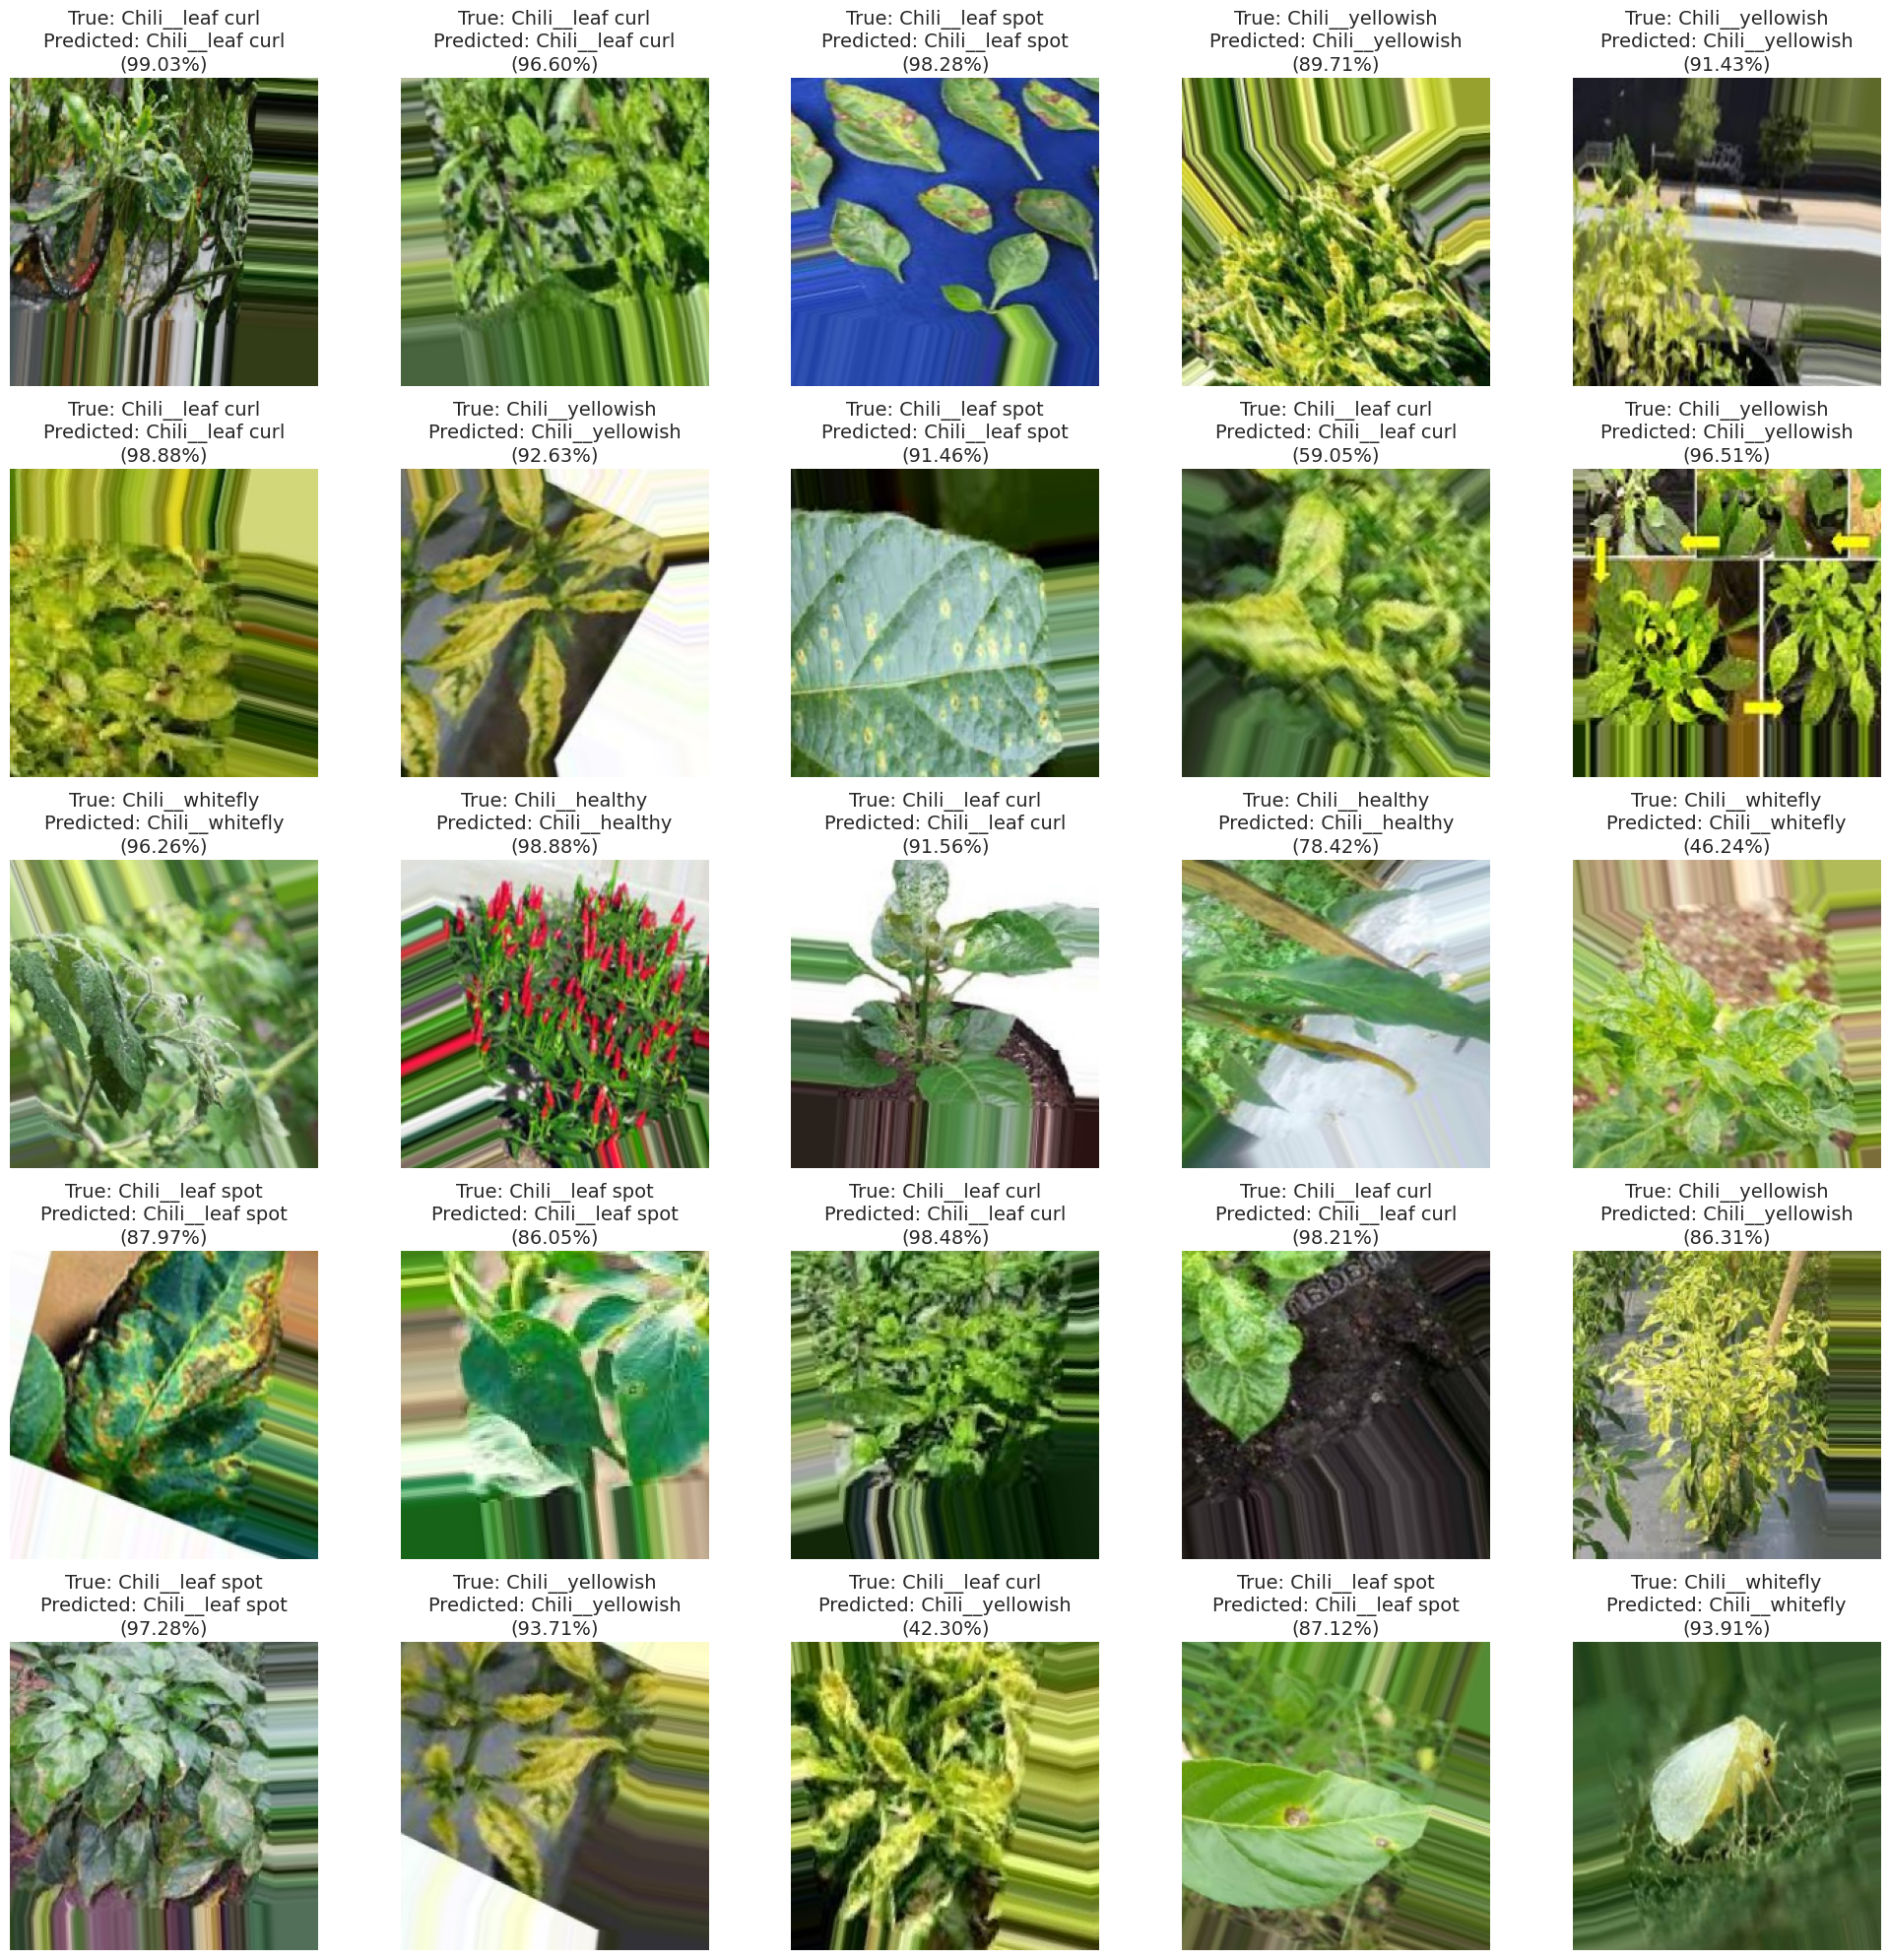

In [54]:
def show_sample_images(generator, model):
    class_dict = generator.class_indices
    classes = list(class_dict.keys())
    images, labels = next(generator)  # get a sample batch from the generator
    predictions = model.predict(images)
    predicted_labels = [classes[np.argmax(pred)] for pred in predictions]
    predicted_probs = np.max(predictions, axis=1)

    plt.figure(figsize=(20, 20))
    length = len(labels)
    if length < 25:  # show maximum of 25 images
        r = length
    else:
        r = 25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        true_label_index = np.argmax(labels[i])
        true_class_name = classes[true_label_index]
        predicted_class_name = predicted_labels[i]
        predicted_prob = predicted_probs[i]
        plt.title(f"True: {true_class_name}\nPredicted: {predicted_class_name}\n({predicted_prob:.2%})", fontsize=14)
        plt.axis('off')

    plt.tight_layout()  # adjust subplot layout
    plt.show()

# Example usage
show_sample_images(train_generator, model)

In [55]:
model.save('CabaiV1_TF.h5')